In [1]:
import numpy as np
import torch
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from pyhmc import hmc


In [2]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='..', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)

# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)



# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# load samples vine
samples_vine = np.load(f'copula_samples_mnist0_t50_scott.npy')
samples_vine = scs.norm.ppf(samples_vine)
# load samples ratio copula
samples_ratio = np.load(f'logsumexpGGCNN_HM100burnin_N01_9_500epoch_samples_mnist.npy')


In [4]:

    #### IGC model



    class SoftRank(nn.Module):
        """Differentiable ranking layer"""
        def __init__(self, alpha=1000.0):
            super(SoftRank, self).__init__()
            self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

        def forward(self, inputs):
            # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
            # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
            x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
            x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
            x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
            return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


    class IGC(nn.Module):
        
        def __init__(self, hidden_size=100, layers_number=2, output_size=2):
            super(IGC, self).__init__()
            self.dim_latent = 3 * output_size
            self.hidden_size = hidden_size
            self.layers_nuber = layers_number
            self.output_size = output_size
            self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
            self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
            self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
            self.marginal_cdfs = None
            self.ecdf_10e6_samples = None

        def forward_train(self, z):
            '''
            Input noise z with shape (M,dim_latent)\\
            Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
            '''
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y).unsqueeze(0)
            u = SoftRank()(y).squeeze(0)
            return u
            
        def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
            n = len(observations_y)
            m = len(simulations_Y)

            # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
            diff_Y_y = torch.pow(
                torch.norm(
                    (observations_y.unsqueeze(1) -
                    simulations_Y.unsqueeze(0)).float(),
                    dim=2,keepdim=True).reshape(-1,1),
                beta)

            # Second part |Y-Y'|. 2* because pdist counts only once.
            diff_Y_Y = 2 * torch.pow(
                nn.functional.pdist(simulations_Y),
                beta)
            Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
            return Energy


        def forward(self, n_samples):
            ''' 
            Function to sample from the copula, once training is done.

            Input: n_samples - number of samples to generate
            Output: torch.tensor of shape (n_samples, output_size) on copula space.
            '''
            with torch.no_grad():
                if self.marginal_cdfs is None:
                    self.marginal_cdfs = []
                    # sample 10^6 points from the latent space and compute empirical marginal cdfs
                    z = torch.randn(10**6, self.dim_latent)
                    y = torch.relu(self.linear_in(z))
                    for layer in range(self.layers_nuber):
                        y = torch.relu(self.linear(y))
                    y = self.linear_out(y) # samples used to approximate cdfs
                    for dim in range(y.shape[1]):
                        ecdf = ECDF(y[:, dim].numpy())
                        self.marginal_cdfs.append(ecdf)
                    self.ecdf_10e6_samples = y
                # sample the latent space and apply ecdfs
                z = torch.randn(n_samples, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y)
                for dim in range(y.shape[1]):
                    y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
                return y


igc_cop = IGC(hidden_size=100, layers_number=3, output_size=28*28)
igc_cop.load_state_dict(torch.load('igc_cop_mnist_10runs_seed0.pth'))
samples_igc = igc_cop.forward_train(torch.randn((25, igc_cop.dim_latent))).detach().numpy()
samples_igc = scs.norm.ppf(samples_igc)

C:\Users\david\AppData\Local\Temp\ipykernel_5784\4122398630.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  igc_cop.load_state_dict(torch.load('igc_cop_mnist_10runs_see

In [5]:
# sample from Gaussian
gauss_cov = np.cov(X_train.reshape(-1, 784).T)

samples_gauss = scs.multivariate_normal.rvs(size=(25), mean=np.zeros(784), cov=gauss_cov+1e-10*np.eye(784))


In [6]:
def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

C:\Users\david\AppData\Local\Temp\ipykernel_5784\1645663503.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j % 5 * 5 + i + 100])).reshape(28, 28), cmap='gray')


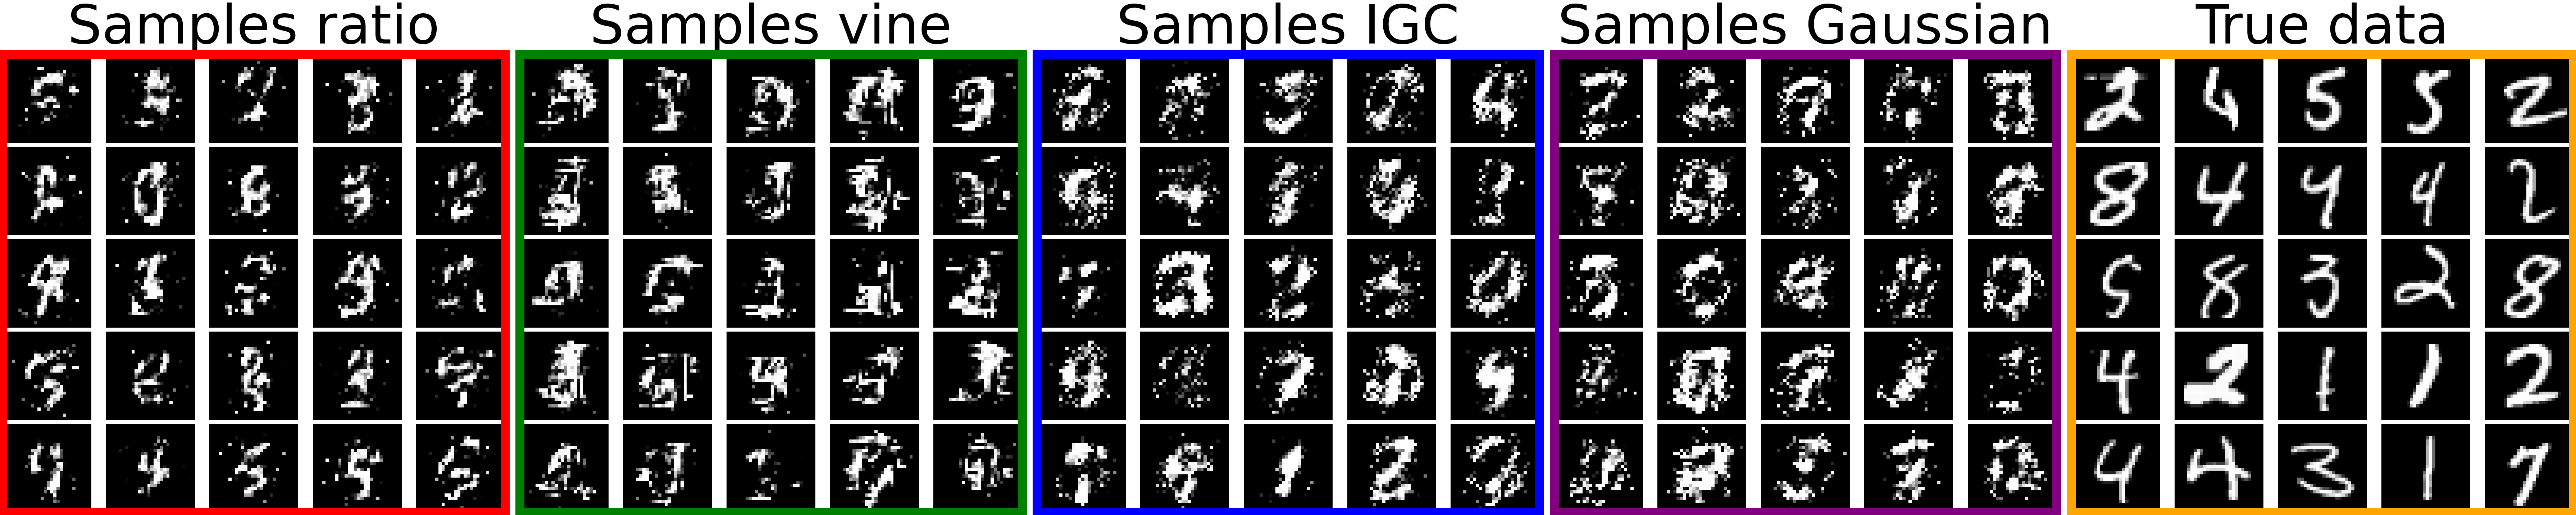

In [7]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Create the subplot grid
fig, axes = plt.subplots(5, 25, figsize=(100, 20))

# Create a function to draw a rectangle around groups of subplots
def draw_subplot_box(fig, start_col, end_col, color):
    # Calculate the bounding box of the group of subplots
    pos0 = axes[0, start_col].get_position()
    pos1 = axes[-1, end_col].get_position()

    # Create a rectangle spanning from top-left to bottom-right of the group
    rect = Rectangle((pos0.x0, pos1.y0), pos1.x1 - pos0.x0, pos0.y1 - pos1.y0,
                     linewidth=25, edgecolor=color, facecolor='none')
    fig.add_artist(rect)

# Create the plots and add an outline for each group of 5x5 plots
for i in range(5):
    for j in range(25):
        if j < 5:  # ratio copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_ratio[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples ratio', fontsize=150)

        if 4 < j < 10:  # vine copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_vine[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples vine', fontsize=150)

        if 9 < j < 15:  # igc copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_igc[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples IGC', fontsize=150)

        if 14 < j < 20:  # Gaussian copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_gauss[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples Gaussian', fontsize=150)

        if j > 19:  # true data
            axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j % 5 * 5 + i + 100])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'True data', fontsize=150)

plt.tight_layout()
# Draw rectangles around the 5x5 blocks of subplots
draw_subplot_box(fig, start_col=0, end_col=4, color='red')       # Ratio Copula
draw_subplot_box(fig, start_col=5, end_col=9, color='green')     # Vine Copula
draw_subplot_box(fig, start_col=10, end_col=14, color='blue')    # IGC Copula
draw_subplot_box(fig, start_col=15, end_col=19, color='purple')  # Gaussian Copula
draw_subplot_box(fig, start_col=20, end_col=24, color='orange')  # True Data
#plt.savefig('mnist_samples.png', bbox_inches='tight', dpi=300)
plt.show()
